# $k$-fold cross validation with purge and emabrgo

$k$-fold cross-validation with purge and embargo is an extension of the traditional [$k$-fold cross-validation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) method for splitting data into training and testing sets. This approach is particularly important for financial data sets with a time component, where classical $k$-fold cross-validation can lead to data leakage since labels are often forward-looking in financial applications.

In this technique, the dataset is divided into $k$ folds, where $k$ is the number of folds specified. Each fold represents a different train-test split. However, unlike traditional cross-validation, the train and test sets are not randomly selected. The dataset is not shuffled. There is no overlap between the time periods in the train and test sets. We assume that observations are monotonically increasing in time. In the `split` method of `quantfinlib` `TimeAwareKFold`, we denote the input features (or observations) by `X`, the labels by `y`, and time periods by `groups`. The latter is named `groups` in order to be consistent with `scikit-learn` naming convention.

To prevent data leakage, we apply two techniques to each train-test split: ***purging*** and ***embargo***. The *purging* period refers to the time interval after each test set, during which some information from the test set may be present in the subsequent training fold. By removing this period from the training set, we ensure that during the training phase, the model is not influenced by information from unseen data. The *embargo* period, on the other hand, corresponds to the time interval before each test set, during which there may be overlap between labels or features in the test fold and its preceding training fold. By removing this period from the training set, we prevent the model from learning from information that is not yet available during training. By incorporating the purge and embargo periods, $k$-fold cross-validation with purge and embargo provides a more realistic evaluation of the model's performance on unseen data.

In this example, the `TimeAwareKFold` class from the `quantfinlib.train_test_split.kfoldpe` module is used to perform $k$-fold cross-validation with purge and embargo. The `n_folds`, `n_embargo`, and `n_purge` parameters are specified to control the number of folds, the duration of the embargo period, and the duration of the purge period, respectively. As an example, we use the `VIX` series from `quantfinlib.datasets.load_equity_indices` to demonstrate purged and embargod $k$-fold train-test split.

In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from quantfinlib.datasets import load_equity_indices
from quantfinlib.train_test_split import TimeAwareKFold
import pandas as pd

We define the input features `X` and time periods `groups` using the VIX series.

In [2]:
vix_series = load_equity_indices()['VIX'].astype(float)
X = pd.DataFrame(vix_series)
groups = vix_series.index

We also define the parameters `n_folds`, `n_embargo`, and `n_purge`.

In [3]:
N_FOLDS = 5
N_EMBARGO = 120
N_PURGE = 120

We define a helper function to visualize the train-test splits for a given $k$-fold splitter.

In [4]:
def visualize_kfold_split(splitter: TimeAwareKFold, title: str) -> None:
    '''Visualize the splits of a TimeAwareKFold object.'''

    fig, ax = plt.subplots(nrows = splitter.get_n_splits(), ncols=1, figsize=(10, 10), sharex=True)
    for split_num, (train_idx, test_idx) in enumerate(splitter.split(X=X, groups=vix_series.index)):
        X.iloc[train_idx].rename({'VIX': 'training set'}, axis=1).plot(color='C0', ax=ax[split_num], linewidth=0, marker='o', markersize=2, label='training set')
        X.iloc[test_idx].rename({'VIX': 'test set'}, axis=1).plot(color='C3', ax=ax[split_num], label='test set')
        ax[split_num].set_title(f'Split {split_num+1} {title}')
        ax[split_num].legend(frameon=False)
    plt.show()
    plt.close()


When instantiating `TimeAwareKFold`, you can optionally set the `look_forward` parameter to `True` or `False`. If `look_forward` is `True`, the test set observations will always be subsequent to those in the corresponding training set. As a result, the first fold is excluded from the train-test split, reducing the total number of splits to `n_folds - 1`. In this example, we will demonstrate the train-test splits for both `look_forward = True` and `look_forward = False` cases.

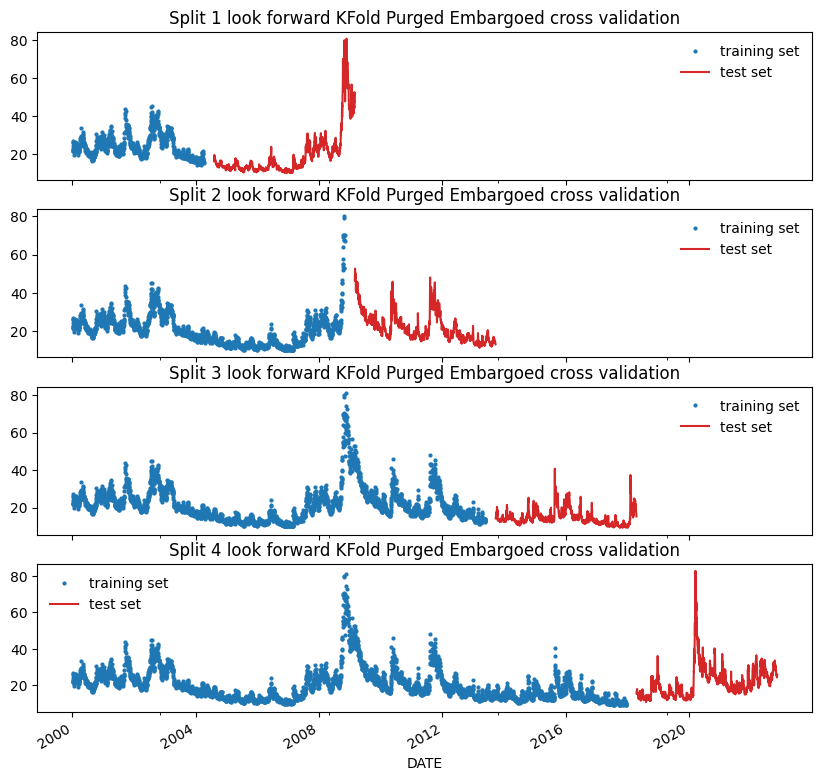

In [5]:
kfold_splitter_with_look_forward = TimeAwareKFold(n_folds=N_FOLDS, n_embargo=N_EMBARGO, n_purge=N_PURGE, look_forward=True, freq='D')
visualize_kfold_split(kfold_splitter_with_look_forward, 'look forward KFold Purged Embargoed cross validation')

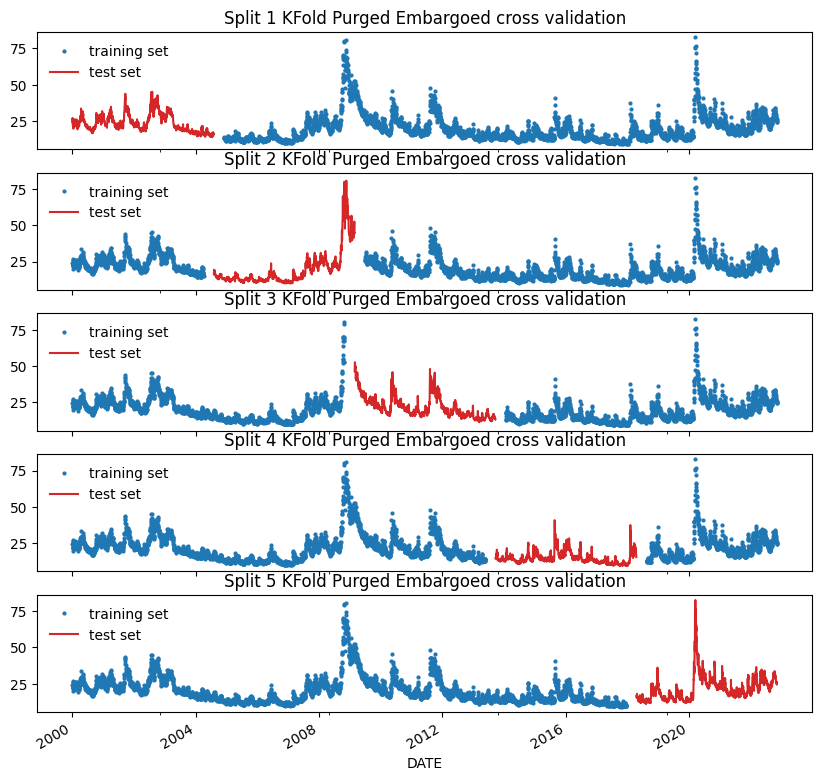

In [6]:
kfold_splitter_without_look_forward = TimeAwareKFold(n_folds=N_FOLDS, n_embargo=N_EMBARGO, n_purge=N_PURGE, look_forward=False, freq='D')
visualize_kfold_split(kfold_splitter_without_look_forward, 'KFold Purged Embargoed cross validation')

## Compatibility with scikit-learn

We can use the `check_cv` function from `sklearn.model_selection` to check if our cross-validator is valid `scikit-learn` cross-validation object. 
If our custom cross-validation is valid `check_cv` will return a cross-validation object that can be used within `scikit-learn` functions that require a cross-validation object as input such as `sklearn.model_selection.cross_val_score` or `sklearn.model_selection.GridSearchCV`. 

In [7]:
from sklearn.model_selection import check_cv

help(check_cv)

In [ ]:
check_cv(cv=kfold_splitter_with_look_forward, y=None, classifier=False)